<a href="https://colab.research.google.com/github/srijitcnair/StockPricePredictionLSTM/blob/master/StockPricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install tensorflow-gpu==2.0.0

     |████████████████████████████████| 380.8MB 38kB/s 
     |████████████████████████████████| 450kB 47.9MB/s 
     |████████████████████████████████| 3.8MB 48.2MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0


In [997]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
from os import path

import pandas_datareader as dr
import matplotlib.pyplot as plt
tf.__version__

'2.0.0'

In [998]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
rootDataFolder = "/content/drive/My Drive/Colab Notebooks/StockLSTMData/"

Mounted at /content/drive


In [0]:
sp500MemberListFile = rootDataFolder+'sp500_constituents.csv'
sp500MemberListFundamentalFile = rootDataFolder+'sp500_constituents_financials.csv'
sp500PickleLocation = rootDataFolder+'sp500data.pkl'
symbolPriceDataLocation = rootDataFolder+'symbol/'

In [0]:
def getDailyPrice(ticker, start, end):
    print('Fetching data for {}'.format(ticker))
    df= dr.get_data_yahoo([ticker], start, end)
    df.columns = df.columns.droplevel(1)
    #df.reset_index(inplace=True)    
    return df

In [0]:
def getPriceForIndex(ticker, start,end):
    return getDailyPrice(ticker,start,end)['Adj Close']

In [0]:
def computeMA(df, column, period):
  ma = df[column].rolling(window=period).mean()
  
  for i in range(period):
    ma[i:period] = np.mean(df[column][0:i+1])
  return ma

In [0]:
def computeBB(df, column, period=20):
  sma = df[column].rolling(window=period).mean()
  std = df[column].rolling(window=period).std()
  for i in range(period):
    sma[i:period] = np.mean(df[column][0:i+1])
    std[i:period] = np.std(df[column][0:i+1])

  upper_band = sma + 2 * std
  lower_band = sma - 2 * std
  width = 4*std
  return (upper_band, lower_band, width, sma)


In [0]:
def getPriceFeaturesForTicker(ticker,start,end):
  tickerPrice = getDailyPrice(ticker,start,end)

  tickerPrice['body'] = tickerPrice['Close']-tickerPrice['Open']
  tickerPrice['range'] = tickerPrice['High']-tickerPrice['Low']
  #tickerPrice['Price_SMA_20'] = computeMA(tickerPrice, 'Adj Close', 20)
  tickerPrice['Price_SMA_5'] = computeMA(tickerPrice, 'Adj Close', 5)
  #tickerPrice['Volume_SMA_20'] = computeMA(tickerPrice, 'Volume', 20)
  tickerPrice['Volume_SMA_5'] = computeMA(tickerPrice, 'Volume', 5)

  (_, _, bb_width,_) = computeBB(tickerPrice, 'Adj Close')
  tickerPrice['BB_width']=bb_width

  indicesToAdd = ['^GSPC','^VIX']

  for indice in indicesToAdd:
      indicePrice = getPriceForIndex(indice,start, end)
      commonDates = tickerPrice.index.intersection(indicePrice.index)
      tickerPrice = tickerPrice.loc[commonDates]
      tickerPrice[indice] = indicePrice.loc[commonDates]
      tickerPrice[indice+'_SMA_5'] = computeMA(tickerPrice, indice, 5)

  tickerPrice.drop(['High','Low','Open','Close'], axis=1, inplace=True)
  tickerPrice.reset_index(inplace=True) 
  return tickerPrice


In [0]:
#print(getPriceFeaturesForTicker('AAPL','01/01/2019','01/31/2019').columns)


In [0]:
def readSavedPriceData(ticker):
    return pd.read_pickle('{}{}.pkl'.format(symbolPriceDataLocation, ticker))

In [0]:
def downloadPriceForTickers(tickers, start, end):
    successCount = 0
    for ticker in tickers:
        try:
            getPriceFeaturesForTicker(ticker, start, end).to_pickle('{}{}.pkl'.format(symbolPriceDataLocation, ticker))
            successCount += 1
        except Exception as e:
            print('Error {} for symbol {}'.format(e, ticker))

    print('Successfully retrieved data for {} stocks'.format(successCount))

In [1035]:
#getDailyPrice('AAPL','01/01/2019','12/31/2019')
start_date = '01/01/2016'
end_date = '12/31/2019'
train_end_date = '06/01/2019'
valid_end_date = '10/01/2019'
ticker = 'GOOG'
num_lookback_days = 10
target_column = 'Adj Close'
downloadPriceForTickers([ticker],start_date,end_date)
data = readSavedPriceData(ticker)

Fetching data for GOOG
Fetching data for ^GSPC
Fetching data for ^VIX
Successfully retrieved data for 1 stocks


In [0]:
def applyPCA(ticker_data):
  pca = PCA(0.95)
  pca.fit(ticker_data)
  print(f'Features picked by PCA: {pca.n_components_}')
  return pca

In [0]:
def preprocessAndSplitData(ticker, target_column, train_date_limit, validation_date_limit, sequence_length):
  ticker_data = readSavedPriceData(ticker)
  
  t = ticker_data[target_column]
  ticker_data.drop(labels=[target_column], axis=1,inplace = True)
  ticker_data.insert(0, target_column, t)

  scaler = MinMaxScaler(feature_range=(-1,1))

  train_data = ticker_data[ticker_data['Date']<train_date_limit].copy()
  train_data.drop('Date',axis=1, inplace=True)
  train_data = scaler.fit_transform(train_data)
  train_data_y = train_data[:,0]
  train_data_x = train_data[:, 1:]
  pca = applyPCA(train_data_x)
  train_data_x = pca.transform(train_data_x)

  valid_data = ticker_data[(ticker_data['Date']>=train_date_limit) & (ticker_data['Date']<validation_date_limit)].copy()
  valid_data.drop('Date',axis=1, inplace=True)
  valid_data = scaler.transform(valid_data)
  valid_data_y = valid_data[:,0]
  valid_data_x = valid_data[:, 1:]
  valid_data_x = pca.transform(valid_data_x)

  test_data = ticker_data[ticker_data['Date']>=validation_date_limit].copy()
  test_data.drop('Date',axis=1, inplace=True)
  test_data = scaler.transform(test_data)
  test_data_y = test_data[:,0]
  test_data_x = test_data[:, 1:]
  test_data_x = pca.transform(test_data_x)

  X_train = []
  Y_train = []
  for i in range(sequence_length,train_data_x.shape[0]):
    X_train.append(np.array(train_data_x[i-sequence_length:i]))
    Y_train.append(train_data_y[i])

  X_valid = []
  Y_valid = []
  for i in range(sequence_length,valid_data_x.shape[0]):
    X_valid.append(np.array(valid_data_x[i-sequence_length:i]))
    Y_valid.append(valid_data_y[i])

  X_test = []
  Y_test = []
  for i in range(sequence_length,test_data_x.shape[0]):
    X_test.append(np.array(test_data_x[i-sequence_length:i]))
    Y_test.append(test_data_y[i])

  X_test = np.array(X_test)
  Y_test = np.array(Y_test)

  return (X_train, Y_train, X_valid, Y_valid, X_test, Y_test, scaler)


In [1038]:

(X_train, Y_train, X_valid, Y_valid, X_test, Y_test, scaler) = preprocessAndSplitData(ticker,target_column,train_end_date, valid_end_date,num_lookback_days)

Features picked by PCA: 5


In [1039]:
print('{},{},{}'.format(len(X_train), len(X_train[0]),len(X_train[0][0])))
print(len(Y_train))
print('--------------------')
print('{},{},{}'.format(len(X_valid), len(X_valid[0]),len(X_valid[0][0])))
print(len(Y_valid))
print('--------------------')
print('{},{},{}'.format(len(X_test), len(X_test[0]),len(X_test[0][0])))
print(len(Y_test))
print('--------------------')

848,10,5
848
--------------------
74,10,5
74
--------------------
54,10,5
54
--------------------


In [0]:
train_data_batch = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_data_batch = train_data_batch.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_data_batch = tf.data.Dataset.from_tensor_slices((X_valid, Y_valid))
val_data_batch = val_data_batch.batch(batch_size).repeat()

test_data_batch = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
test_data_batch = test_data_batch.batch(batch_size).repeat()

num_features = len(X_train[0][0])
batch_size = 100
buffer_size = 10000


In [0]:
model = Sequential()

model.add(LSTM(units=64,input_shape=[num_lookback_days,num_features]))#, return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(units=12, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='relu'))
#model.add(Dropout(0.2))

#model.add(LSTM(units=128,return_sequences=True))
#model.add(Dropout(0.2))

#model.add(LSTM(units=5))
#model.add(Dropout(0.2))

#model.add(LSTM(units=24, activation='relu'))
#model.add(Dropout(0.4))

#model.add(LSTM(units=128, activation='relu'))
#model.add(Dropout(0.4))

#model.add(Dense(units=32, activation='relu'))


In [1042]:
model.summary()


Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_143 (LSTM)              (None, 64)                17920     
_________________________________________________________________
dropout_149 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_135 (Dense)            (None, 12)                780       
_________________________________________________________________
dropout_150 (Dropout)        (None, 12)                0         
_________________________________________________________________
dense_136 (Dense)            (None, 1)                 13        
Total params: 18,713
Trainable params: 18,713
Non-trainable params: 0
_________________________________________________________________


In [0]:
#optimizer = tf.keras.optimizers.RMSprop(0.001)

model.compile(optimizer='adam', loss='mean_squared_error')

In [1044]:
for x, y in test_data_batch.take(1):
  print(x.shape)
  print(model.predict(x).shape)

(54, 10, 5)
(54, 1)


In [1045]:
epochs = 100
evaluation_interval = 50
es_callback = EarlyStopping(monitor='val_loss', patience=10)
model.fit(train_data_batch, epochs=epochs,
          steps_per_epoch=evaluation_interval,
          validation_data=val_data_batch,
          validation_steps=evaluation_interval,callbacks=[es_callback])

Train for 50 steps, validate for 50 steps
Epoch 1/100
50/50 [==============================] - 5s 105ms/step - loss: 0.2275 - val_loss: 0.0250
Epoch 2/100
50/50 [==============================] - 2s 39ms/step - loss: 0.2076 - val_loss: 0.0330
Epoch 3/100
50/50 [==============================] - 2s 40ms/step - loss: 0.2053 - val_loss: 0.0366
Epoch 4/100
50/50 [==============================] - 2s 39ms/step - loss: 0.2032 - val_loss: 0.0340
Epoch 5/100
50/50 [==============================] - 2s 39ms/step - loss: 0.2030 - val_loss: 0.0394
Epoch 6/100
50/50 [==============================] - 2s 38ms/step - loss: 0.2020 - val_loss: 0.0379
Epoch 7/100
50/50 [==============================] - 2s 42ms/step - loss: 0.2017 - val_loss: 0.0387
Epoch 8/100
50/50 [==============================] - 2s 41ms/step - loss: 0.2007 - val_loss: 0.0573
Epoch 9/100
50/50 [==============================] - 2s 39ms/step - loss: 0.1991 - val_loss: 0.0404
Epoch 10/100
50/50 [==============================] - 2s 

In [1046]:
Y_pred = model.predict(X_test) * (1/scaler.scale_[0])
Y_pred[0:10]

array([[243.32063],
       [268.73438],
       [281.3316 ],
       [292.42685],
       [284.5193 ],
       [284.54114],
       [286.44992],
       [302.30432],
       [303.0556 ],
       [317.5208 ]], dtype=float32)

In [1047]:
Y_test_scaled = Y_test.reshape(-1, 1) * (1/scaler.scale_[0])
Y_test_scaled[0:10]

array([[265.09002686],
       [265.72003174],
       [275.14996338],
       [267.57000732],
       [268.2300415 ],
       [264.88006592],
       [281.21002197],
       [283.07000732],
       [287.21002197],
       [312.08001709]])

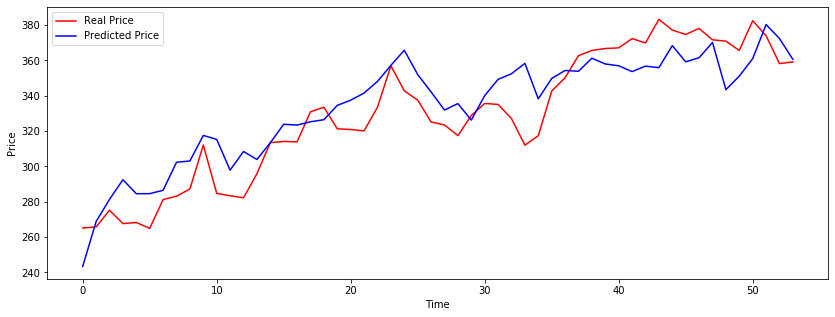

In [1048]:
plt.figure(figsize=(14,5))
plt.plot(Y_test_scaled, color = 'red', label = 'Real Price')
plt.plot(Y_pred, color = 'blue', label = 'Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()